In [51]:
import pandas as pd
import numpy as np

import requests

import os
import time
from datetime import datetime
import sys
import yaml
import gc

from data_loader import *
from utils import *
from nn import *
from models import *
from llm import *
from llm_hf import *
from visualizations import *
import folder_manager


import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#1e1e1e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.grid': True,
    'grid.color': 'gray'
})


pd.set_option("display.max_column",None)
print(os.getcwd())


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

pd.options.display.max_rows = 100


def auto_reload():
    %load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("config.yaml",'r') as f:
    config = yaml.safe_load(f)

home_dir = config['HOME_DIRECTORY']
home_dir

'/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG'

# API Football:
https://www.api-football.com

![PYTHON LOGO](https://www.api-football.com/public/img/news/archi-beta.jpg)

In [3]:
leagues_dat = pd.read_sql("select * from overperformxg.league",config['MYSQL_STRING'])
leagues_dat[['league_id','league_name','country_name']]

,league_id,league_name,country_name
0,4,Euro Championship,World
1,21,Confederations Cup,World
2,61,Ligue 1,France
3,144,Jupiler Pro League,Belgium
4,71,Serie A,Brazil
...,...,...,...
2261,1131,Super Cup,Mongolia
2262,1132,AFC Challenge League,World
2263,1133,Goiano - 3,Brazil
2264,1001,CONCACAF Women U20,World


# Read All fixtures data

In [4]:
teams_dat = pd.read_sql("select * from overperformxg.team_league_map",config['MYSQL_STRING'])
teams_dat.head()

,team_name,league
0,Angers,61
1,Lille,61
2,Lyon,61
3,Marseille,61
4,Nantes,61


In [5]:
# Read player_fixture_data
complete_data = pd.read_sql("select * from overperformxg.complete_data",config['MYSQL_STRING'])
# Drop Duplicates
complete_data.drop_duplicates(inplace=True)

In [6]:
# Data checks
complete_data['passes_accurate'] = complete_data['passes_accurate'].astype("float64")
complete_data['fixture_date'] = pd.to_datetime(complete_data.fixture_date)
complete_data['games_rating'] = pd.to_numeric(complete_data['games_rating'])

In [7]:
complete_data[complete_data.games_minutes.notna()].tail()

,player_id,player_name,offsides,games_minutes,games_number,games_position,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,fixture_id,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,opponent,fixture_date,team_winner,team,outcome,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,fixture_date_dt,year_e,month_e,month_name_e,day_of_week_e,day_of_week_name_e,week_e,season,outcome_num,win,draw,loss,league,league_id,league_name
488021,249,Donyell Malen,NaN,61.0,17,F,6.5,0,0,1.0,NaN,NaN,0,0.0,NaN,4.0,NaN,3.0,NaN,NaN,NaN,4.0,1.0,NaN,NaN,1.0,NaN,1.0,0,0,NaN,NaN,0,0,NaN,1379047,2,2.0,1,1,1.0,1,Tottenham,2025-10-19 13:00:00,Aston Villa,Aston Villa,win,NaN,NaN,25.000000,75.000000,2025-10-19,2025.0,2025-10-01,October,6.0,Sunday,2025-10-14,2025/2026,2,1,0,0,39,39,Premier League
488022,19071,Emiliano Buendía,NaN,29.0,10,M,8.2,0,1,1.0,1.0,1.0,0,0.0,NaN,10.0,NaN,10.0,2.0,NaN,NaN,7.0,4.0,1.0,1.0,NaN,1.0,1.0,0,0,NaN,NaN,0,0,NaN,1379047,2,2.0,1,1,1.0,1,Tottenham,2025-10-19 13:00:00,Aston Villa,Aston Villa,win,100.0,100.0,57.142857,100.000000,2025-10-19,2025.0,2025-10-01,October,6.0,Sunday,2025-10-14,2025/2026,2,1,0,0,39,39,Premier League
488023,19366,Ollie Watkins,NaN,29.0,11,F,6.3,0,1,NaN,NaN,NaN,0,0.0,NaN,13.0,NaN,10.0,NaN,NaN,NaN,9.0,3.0,4.0,1.0,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1379047,2,2.0,1,1,1.0,1,Tottenham,2025-10-19 13:00:00,Aston Villa,Aston Villa,win,25.0,NaN,33.333333,76.923077,2025-10-19,2025.0,2025-10-01,October,6.0,Sunday,2025-10-14,2025/2026,2,1,0,0,39,39,Premier League
488024,138816,Ian Maatsen,NaN,8.0,22,D,7.2,0,1,1.0,NaN,NaN,0,0.0,NaN,4.0,1.0,4.0,2.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1379047,2,2.0,1,1,1.0,1,Tottenham,2025-10-19 13:00:00,Aston Villa,Aston Villa,win,NaN,NaN,100.000000,100.000000,2025-10-19,2025.0,2025-10-01,October,6.0,Sunday,2025-10-14,2025/2026,2,1,0,0,39,39,Premier League
488025,2287,Ross Barkley,NaN,8.0,6,M,6.6,0,1,NaN,NaN,NaN,0,0.0,NaN,6.0,NaN,5.0,1.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1379047,2,2.0,1,1,1.0,1,Tottenham,2025-10-19 13:00:00,Aston Villa,Aston Villa,win,NaN,NaN,50.000000,83.333333,2025-10-19,2025.0,2025-10-01,October,6.0,Sunday,2025-10-14,2025/2026,2,1,0,0,39,39,Premier League


In [8]:
# This is the dictionary that contains all information about the features    
dat_dict = find_data_types(complete_data,config['OUTCOME_COLS'] + ['outcome_num','outcome'])
dat_dict = pd.DataFrame(list(dat_dict.items()),columns =['feature','type'])

# differentiate modeling features
non_modeling_features = config['FIXTURE_COLS'] + config['OUTCOME_COLS'] + config['MISC_COLS'] + ['outcome_num','league','win','fixture_date','season','fixture_date_dt','major_position','draw','loss']
dat_dict['modeling_feature'] = np.where(dat_dict['feature'].isin(non_modeling_features),0,1)
dat_dict['encoded'] = 0

print(dat_dict['type'].value_counts())
dat_dict.reset_index(drop= True)

## Encode Features
dat_dict = create_data_index(complete_data,dat_dict,'target',folder_manager.encoding_path)
show(dat_dict[dat_dict.modeling_feature ==1])

type
numeric        45
target         10
categorical     8
datetime        3
Name: count, dtype: int64


Loading ITables v2.6.1 from the internet... (need help?)


# Data Checks

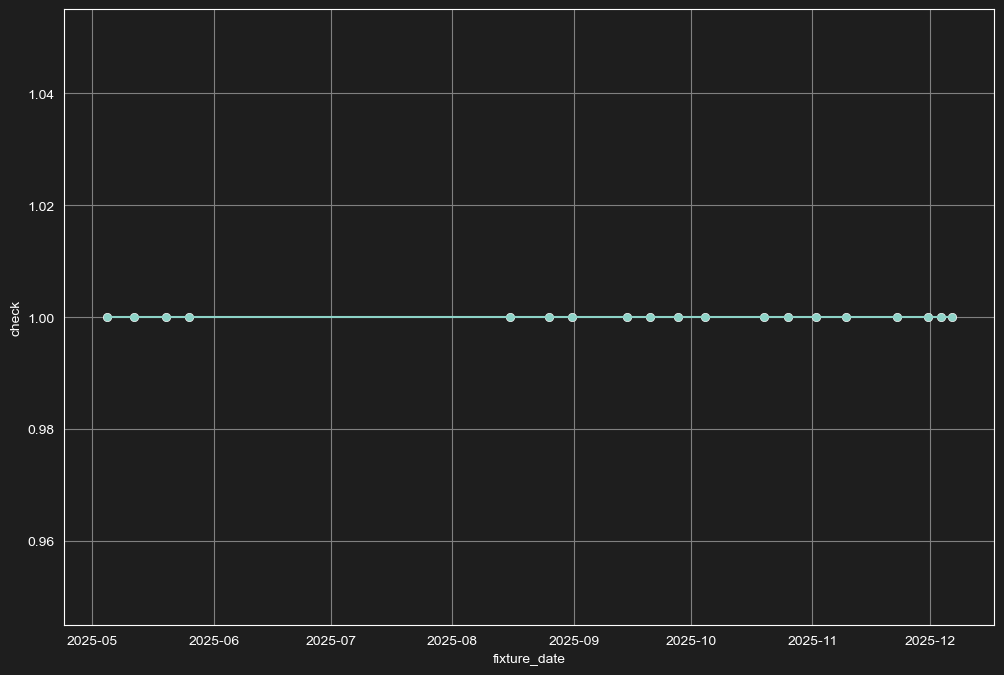

In [9]:
min_date_team = '2025-05-01'
team_to_check = 'Liverpool'
team_population = complete_data[complete_data.team == team_to_check][['fixture_date','fixture_id']]
datewise = team_population.groupby('fixture_date',as_index=False).agg(num_players = ('fixture_date','count'))
datewise['check'] = 1

datewise = datewise[datewise.fixture_date >= min_date_team]
fig,axes = plt.subplots(figsize = (12,8))
sns.lineplot(datewise,x = 'fixture_date', y ='check',markers='0',ax= axes)
sns.scatterplot(datewise,x = 'fixture_date', y ='check',markers='0',ax= axes)
plt.show()

In [ ]:
# Run Player Comparison from LLm 
#player_compare  = compare_players_from_llm(complete_data,["Giovanni Leoni","Ibrahima Konaté"],years = [2025],normalize=True)

# Clustering Opponents

## Method 1: Decision Tree

In [77]:
fixture_dat = calculate_fixture_stats(complete_data)
fixture_dat.drop_duplicates(inplace = True)
print(fixture_dat.shape)
fixture_dat.head()

(22238, 164)


,fixture_id,team,offsides,games_minutes_median,games_number,games_rating,games_substitute,shots_total,shots_on,goals_total,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,win,draw,loss,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,team_winner,opponent,goal_diff,week_e,year_e,season,fixture_date,l3_win,l3_draw,l3_loss,l5_win,l5_draw,l5_loss,offsides_opp,games_minutes_median_opp,games_number_opp,games_rating_opp,games_substitute_opp,shots_total_opp,shots_on_opp,goals_total_opp,goals_assists_opp,goals_saves_opp,passes_total_opp,passes_key_opp,passes_accurate_opp,tackles_total_opp,tackles_blocks_opp,tackles_interceptions_opp,duels_total_opp,duels_won_opp,dribbles_attempts_opp,dribbles_success_opp,dribbles_past_opp,fouls_drawn_opp,fouls_committed_opp,cards_yellow_opp,cards_red_opp,penalty_won_opp,penalty_commited_opp,penalty_scored_opp,penalty_missed_opp,penalty_saved_opp,dribble_success_rate_opp,target_shot_conversion_perc_opp,duels_won_perc_opp,pass_accuracy_perc_opp,win_opp,draw_opp,loss_opp,team_goals_scored_opp,team_non_penalty_goals_scored_opp,team_goals_scored_half_opp,team_goals_conceded_opp,team_non_penalty_goals_conceded_opp,team_goals_conceded_half_opp,team_winner_opp,goal_diff_opp,week_e_opp,year_e_opp,season_opp,fixture_date_opp,l3_win_opp,l3_draw_opp,l3_loss_opp,l5_win_opp,l5_draw_opp,l5_loss_opp,offsides_dev,games_minutes_median_dev,games_number_dev,games_rating_dev,games_substitute_dev,shots_total_dev,shots_on_dev,goals_total_dev,goals_assists_dev,goals_saves_dev,passes_total_dev,passes_key_dev,passes_accurate_dev,tackles_total_dev,tackles_blocks_dev,tackles_interceptions_dev,duels_total_dev,duels_won_dev,dribbles_attempts_dev,dribbles_success_dev,dribbles_past_dev,fouls_drawn_dev,fouls_committed_dev,cards_yellow_dev,cards_red_dev,penalty_won_dev,penalty_commited_dev,penalty_scored_dev,penalty_missed_dev,penalty_saved_dev,dribble_success_rate_dev,target_shot_conversion_perc_dev,duels_won_perc_dev,pass_accuracy_perc_dev,win_dev,draw_dev,loss_dev,team_goals_scored_dev,team_non_penalty_goals_scored_dev,team_goals_scored_half_dev,team_goals_conceded_dev,team_non_penalty_goals_conceded_dev,team_goals_conceded_half_dev,goal_diff_dev,year_e_dev,l3_win_dev,l3_draw_dev,l3_loss_dev,l5_win_dev,l5_draw_dev,l5_loss_dev
0,1223983,1. FC Heidenheim,0.0,81.0,16.277778,6.900000,8,5.0,3.0,2.0,2.0,0.0,312.0,4.0,222.0,17.0,1.0,8.0,118.0,58.0,19.0,8.0,4.0,9.0,15.0,3,0,0.0,0.0,0,0,0.0,73.333333,100.000000,55.874642,69.948108,1,0,0,2,2.0,0,0,0.0,0,1. FC Heidenheim,FC St. Pauli,2,2024-08-20,2024.0,2024/2025,2024-08-25 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,80.0,15.777778,6.742857,8,10.0,3.0,0.0,0.0,0.0,500.0,9.0,401.0,25.0,0.0,7.0,119.0,60.0,10.0,4.0,8.0,15.0,9.0,2,0,0.0,0.0,0,0,0.0,54.166667,0.000000,50.952496,80.879397,0,0,1,0,0.0,0,2,2.0,0,1. FC Heidenheim,-2,2024-08-20,2024.0,2024/2025,2024-08-25 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1.0,0.500000,0.157143,0,-5.0,0.0,2.0,2.0,0.0,-188.0,-5.0,-179.0,-8.0,1.0,1.0,-1.0,-2.0,9.0,4.0,-4.0,-6.0,6.0,1,0,0.0,0.0,0,0,0.0,19.166667,100.000000,4.922146,-10.931290,1,0,-1,2,2.0,0,-2,-2.0,0,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1223988,1. FC Heidenheim,1.0,70.0,16.277778,7.353333,8,13.0,8.0,4.0,2.0,0.0,268.0,10.0,207.0,19.0,4.0,12.0,108.0,56.0,21.0,10.0,5.0,9.0,15.0,1,0,0.0,0.0,1,0,0.0,76.666667,83.333333,52.482401,78.213158,1,0,0,4,4.0,2,0,0.0,0,1. FC Heidenheim,FC Augsburg,4,2024-08-27,2024.0,2024/2025,2024-09-01 13:30:00,1.0,0.0,0.0,1.0,0.0,0.0,1.0,59.0,17.333333,6.560000,8,12.0,1.0,0.0,0.0,0.0,496.0,9.0,415.0,16.0,2.0,6.0,109.0,52.0,16.0,5.0,10.0,15.0,10.0,4,0,0.0,1

In [78]:
# Data Dictionary for Fixtures
dat_dict_fixture = find_data_types(fixture_dat,[find_columns(fixture_dat,'win') + find_columns(fixture_dat,'goal')])
dat_dict_fixture = pd.DataFrame(list(dat_dict_fixture.items()),columns =['feature','type'])

non_modeling_features = ['fixture_id','team','win','loss',
                        'draw','opponent','team_winner_opp',
                        'win_opp','loss_opp','draw_opp','win_dev',
                        'loss_dev','draw_dev','team_winner','split_date','split']  +  find_columns(fixture_dat,'goal') + find_columns(fixture_dat,'games_number') + find_columns(fixture_dat,'games_substitute') + find_columns(fixture_dat,'loss') +  find_columns(fixture_dat,'year') + find_columns(fixture_dat,'season') + find_columns(fixture_dat,'games_rating') + find_columns(fixture_dat,'target_shot_conversion_perc')
dat_dict_fixture['modeling_feature'] = np.where(dat_dict_fixture['feature'].isin(non_modeling_features),0,1)
dat_dict_fixture['encoded'] = 0
show(dat_dict_fixture[dat_dict_fixture.modeling_feature == 1])

Loading ITables v2.6.1 from the internet... (need help?)


In [ ]:
fig,axes = plt.subplots(figsize = (15,15))
sns.heatmap(fixture_dat[dat_dict_fixture[(dat_dict_fixture.modeling_feature == 1) & (dat_dict_fixture.type == 'numeric')]['feature']].corr(),cmap = 'coolwarm',ax=axes)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 80, ha = 'right')
plt.show()

In [ ]:
# Understand feature relations
# Check with win model:

# Split data
if "split" not in fixture_dat.columns:
    fixture_dat = split_by_team(fixture_dat,.75)

x_train = fixture_dat[fixture_dat.split == 'train'][dat_dict_fixture[(dat_dict_fixture.modeling_feature == 1) & (dat_dict_fixture.type.isin(["numeric",'categorical']))]['feature']]
x_test = fixture_dat[fixture_dat.split == 'test'][dat_dict_fixture[(dat_dict_fixture.modeling_feature == 1) & (dat_dict_fixture.type.isin(["numeric",'categorical']))]['feature']]
y_train = fixture_dat[fixture_dat.split == 'train']['games_rating']
y_test = fixture_dat[fixture_dat.split == 'test']['games_rating']

In [ ]:
create_submodel("catboost_feature_games_rating")

In [ ]:
model = run_model_with_fs_tune(x_train,x_test,y_train,y_test,dat_dict_fixture,"catboost",folder_manager.output_path)

In [79]:
# pred on all fixtures
current_model = False
model = '/outputs/models/19_21_29_catboost_feature_games_rating'

if current_model:
    model_path = folder_manager.output_path
else:
    model_path = config['HOME_DIRECTORY'] + model    
fixture_pred = predict_final(model_path,fixture_dat,['fixture_id','team'])

print("main data shape: ", fixture_dat.shape)
print("predicted data shape: ", fixture_pred.shape)

fixture_pred

Applying CatBoost preprocessing
Input columns used for prediction:
['games_minutes_median', 'shots_total', 'shots_on', 'passes_total', 'passes_key', 'passes_accurate', 'tackles_total', 'tackles_blocks', 'tackles_interceptions', 'duels_won', 'fouls_drawn', 'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_commited', 'dribble_success_rate', 'duels_won_perc', 'pass_accuracy_perc', 'l5_win', 'games_minutes_median_opp', 'passes_total_opp', 'passes_accurate_opp', 'tackles_total_opp', 'tackles_interceptions_opp', 'duels_won_opp', 'fouls_drawn_opp', 'fouls_committed_opp', 'penalty_scored_opp', 'dribble_success_rate_opp', 'duels_won_perc_opp', 'pass_accuracy_perc_opp', 'games_minutes_median_dev', 'shots_total_dev', 'shots_on_dev', 'passes_total_dev', 'passes_key_dev', 'passes_accurate_dev', 'tackles_total_dev', 'tackles_blocks_dev', 'tackles_interceptions_dev', 'duels_won_dev', 'cards_red_dev', 'penalty_scored_dev', 'dribble_success_rate_dev', 'duels_won_perc_dev', 'pass_accuracy_perc_de

,fixture_id,team,prediction
0,1223983,1. FC Heidenheim,6.624557
1,1223988,1. FC Heidenheim,6.753738
2,1223994,1. FC Heidenheim,6.528524
3,1224005,1. FC Heidenheim,6.519366
4,1224017,1. FC Heidenheim,6.699882
...,...,...,...
22805,1379028,Wolves,6.620632
22806,1379062,Wolves,6.526832
22807,1379089,Wolves,6.563589
22808,1379108,Wolves,6.580379


In [ ]:
fig,axes = plt.subplots(figsize = (8,8))
sns.kdeplot(fixture_pred,x = 'pred_probability',ax=axes)
plt.show()

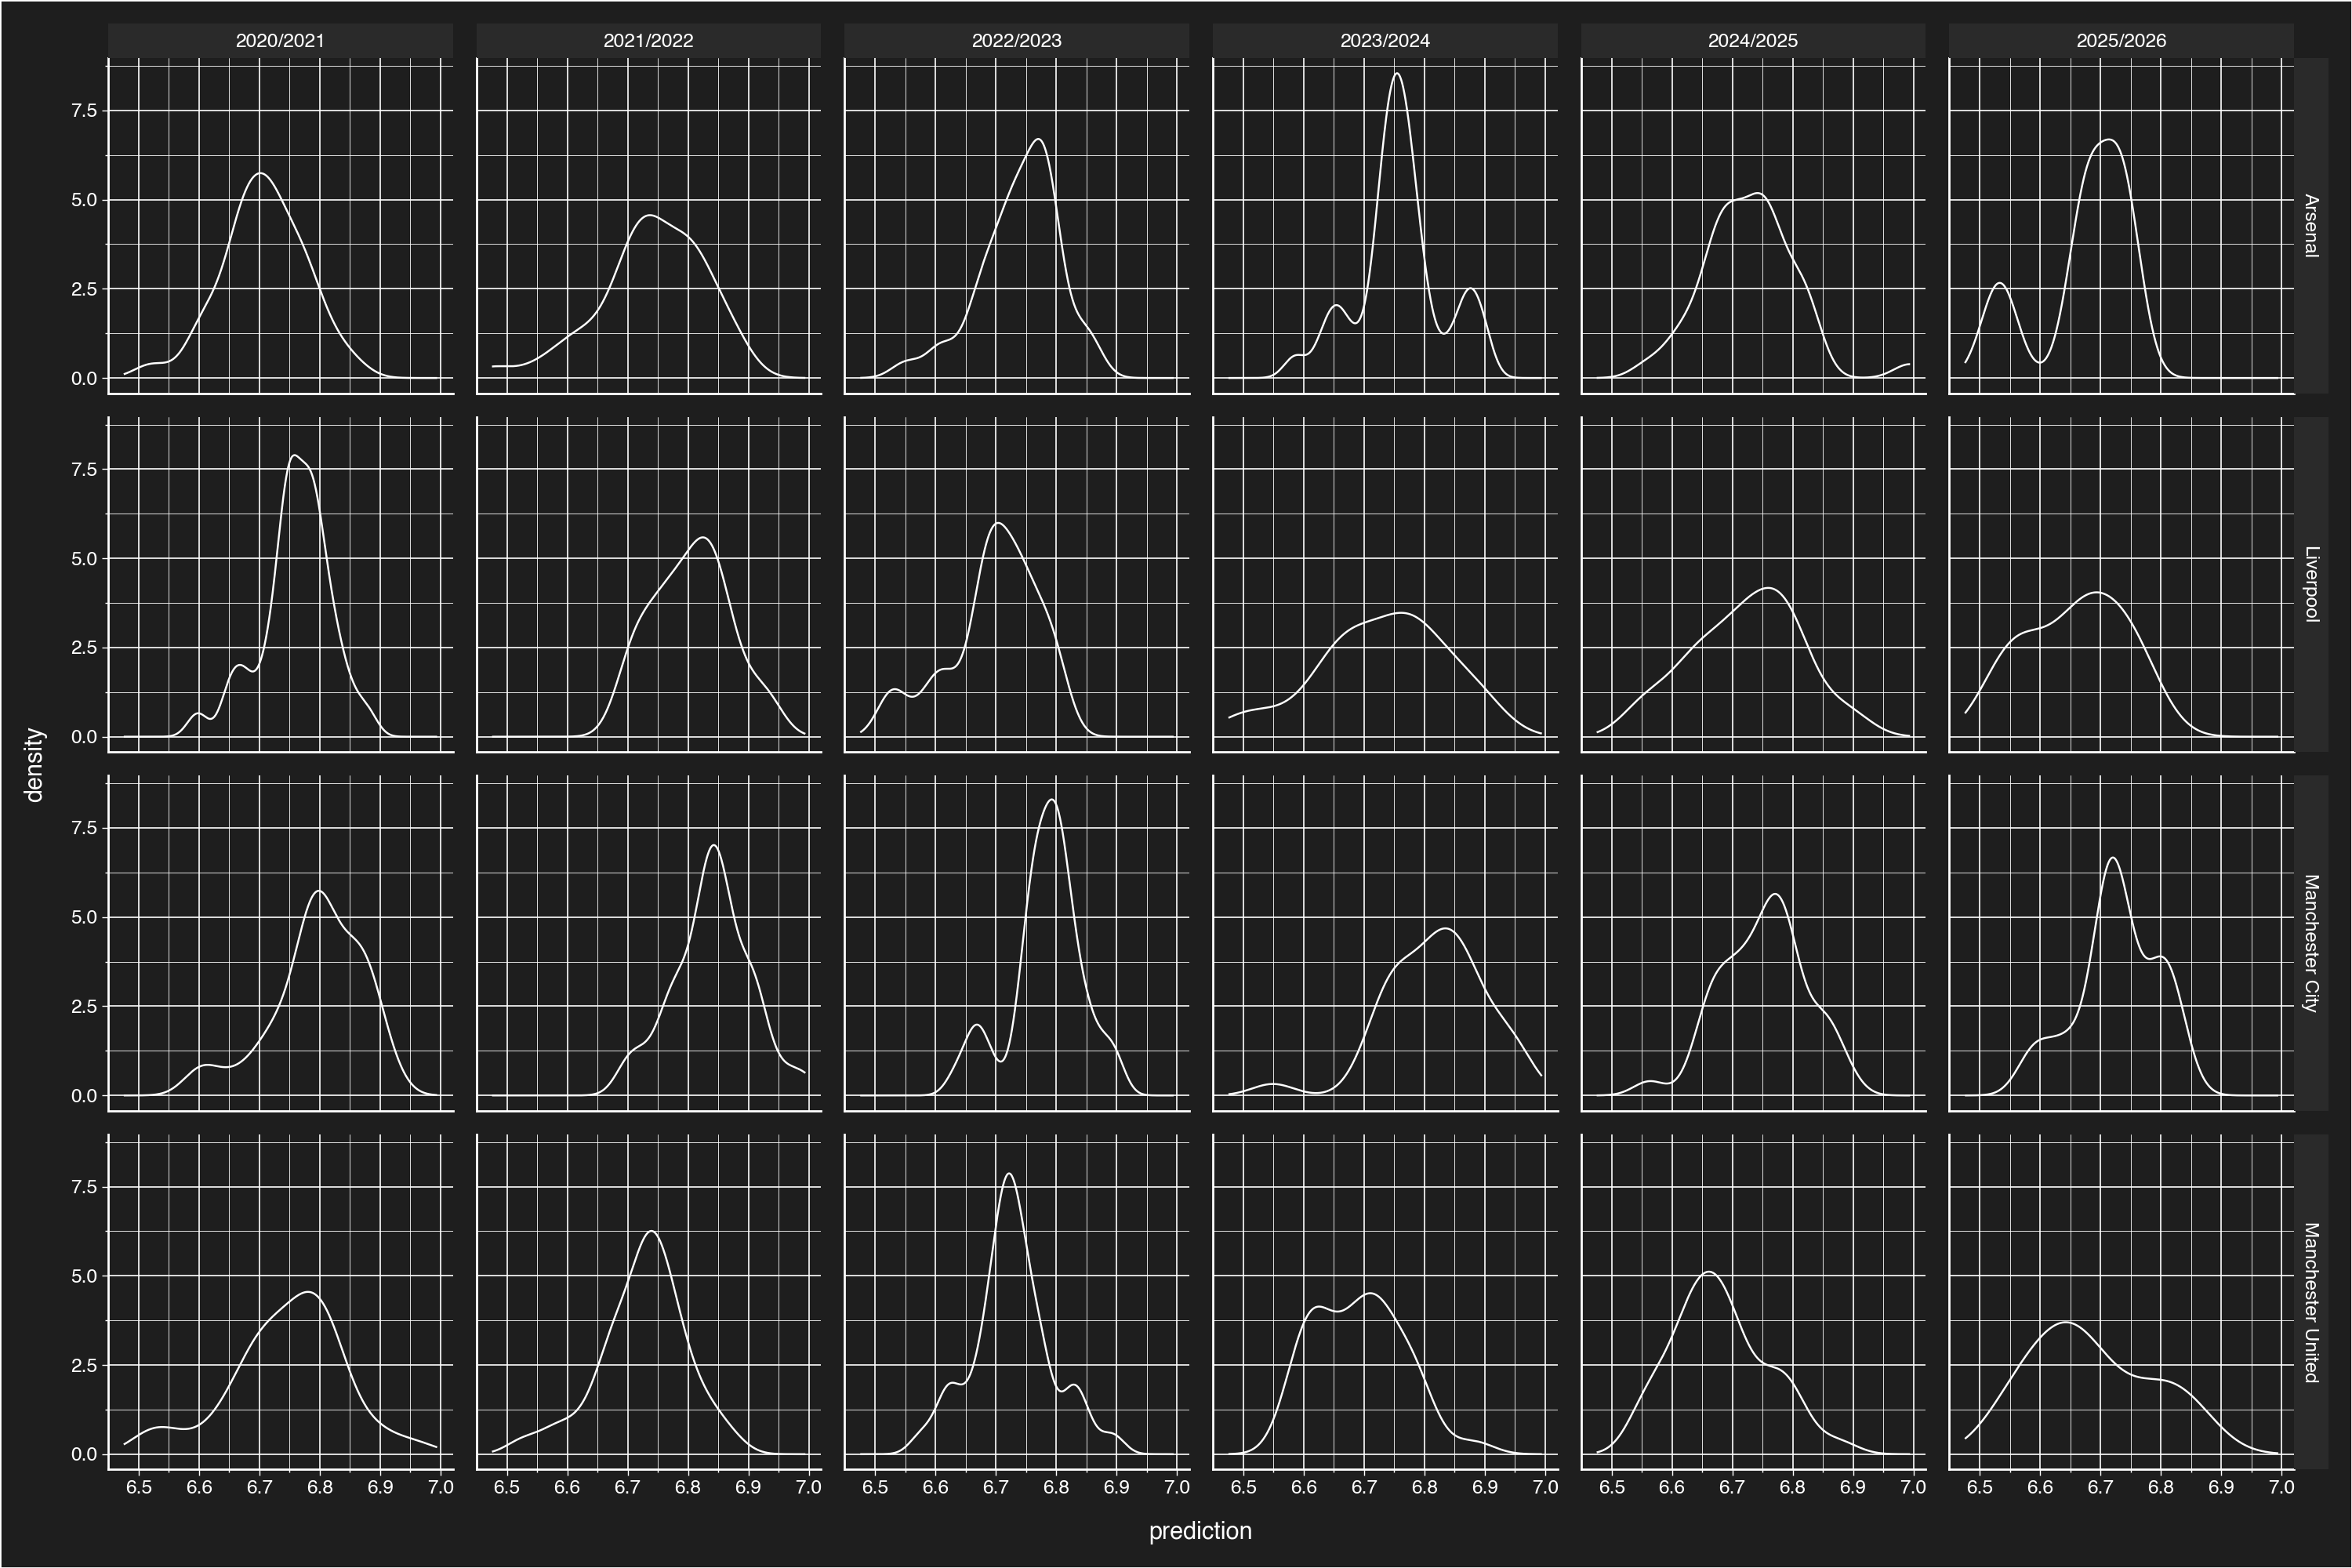

In [80]:
# Config to plot prediction distribution
pred_col = 'prediction'
teams_filter = ['Arsenal','Liverpool','Manchester City','Manchester United']

if "pred_probability" not in fixture_dat.columns or "pred_cont" not in fixture_dat.columns:
    fixture_dat = fixture_dat.merge(fixture_pred,how = 'left',on = ['fixture_id','team'])

p = (
    ggplot(
        fixture_dat[fixture_dat.team.isin(teams_filter)],
        aes(x=pred_col)
    )
    + geom_density(color='#ffffff')
    + facet_grid('team ~ season', scales='fixed')
    + theme_bw()
    + dark_maximal
    + theme(figure_size=(15,10))
)
p


In [104]:
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor, plot_tree

target_dt = 'prediction'
problem_type = infer_target_type(fixture_dat,target_dt)


if problem_type == 'classification':
    tree = DecisionTreeClassifier(max_depth=4,criterion= 'entropy')
else:
    tree = DecisionTreeRegressor(max_depth=4)
tree_model = tree.fit(fixture_dat[[target_dt]], fixture_dat.win.values)


Loading ITables v2.6.1 from the internet... (need help?)


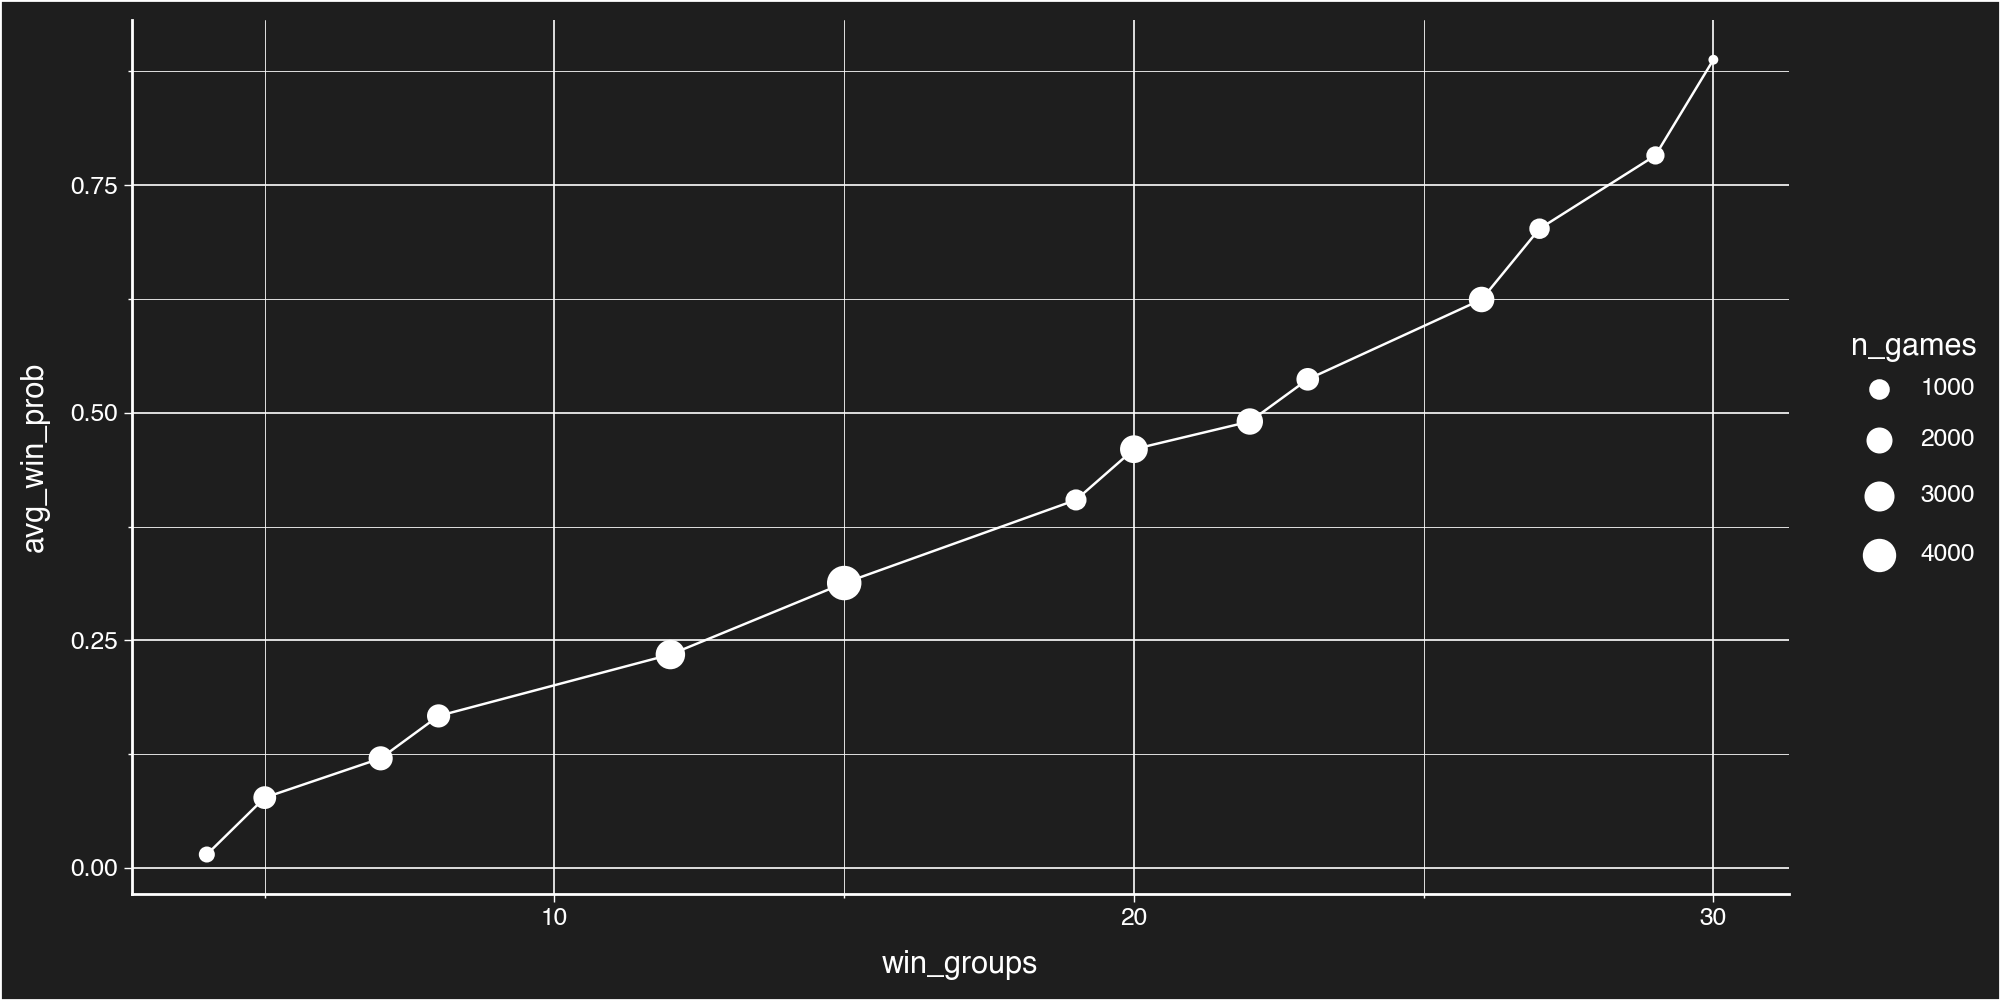

In [108]:
if 'win_groups' not in fixture_dat.columns:
    fixture_dat['win_groups'] = tree_model.apply(fixture_dat[[target_dt]])
group_win_rate = fixture_dat.groupby('win_groups',as_index = False).agg(n_games = ('win_groups','count'),avg_win_prob = ('win','mean')).sort_values('avg_win_prob',ascending = False)
show(group_win_rate)
g = (
    ggplot(group_win_rate[group_win_rate.n_games > 30],aes(x = 'win_groups', y= 'avg_win_prob'))
    + geom_line(color = 'white')
    + geom_point(aes(size = 'n_games'),color = 'white')
    + dark_maximal
    + theme(figure_size = (10,5))
)
g


In [ ]:
min_minutes = 10
target = 'games_rating'


with pm.model as model():
    


In [ ]:
# team Cluster by tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import OrdinalEncoder

target_col = 'win'

# Data to train Decision Tree on
# team_class_dat = fixture_dat[['fixture_id','team','opponent','season','win']].drop_duplicates()
team_class_dat = fixture_dat[list(set(['fixture_id','team','opponent','season','league_name',
'games_rating','shots_total','shots_on','passes_key','passes_accurate','duels_total','duels_won','fouls_drawn',
'dribble_success_rate','target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','fouls_committed','penalty_won'] + [target_col])) ].drop_duplicates()

model_cols = []#['opponent_encoded,'games_rating','shots_total','shots_on','passes_key','passes_accurate','duels_total','duels_won','fouls_drawn','dribble_success_rate','target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','fouls_committed','penalty_won']


# Encode Non numeric features
oe = OrdinalEncoder()
team_class_dat['team_encoded'] = oe.fit_transform(team_class_dat['team'])
team_class_dat['opponent_encoded'] = oe.transform(team_class_dat.drop(columns = 'team').rename(columns={"opponent":'team'})['team']).astype("int")
team_class_dat.head()
team_class_dat['team_cluster'] = 0

for league, season in team_class_dat[['league_name', 'season']].drop_duplicates().itertuples(index=False):
    if season != np.nan:
        print(f"for season {season}, and league {league}")
        dtc = DecisionTreeClassifier(max_depth=4)
        print("Using cols: ", ['team_encoded'] + model_cols )
        model = dtc.fit(team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][['team_encoded'] + model_cols],team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][target_col].values)
        y_pred = model.predict(team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][['team_encoded']+ model_cols])
        team_class_dat.loc[(team_class_dat.season == season) & (team_class_dat.league_name == league),'team_cluster'] = model.predict_proba(team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][['team_encoded']+ model_cols]).max(axis = 1)

team_cluster_map = team_class_dat[['season','league_name','team','team_cluster']].drop_duplicates().reset_index(drop= True)
team_class_dat = team_class_dat.merge(team_cluster_map,left_on = ['season','league_name','opponent'],right_on = ['season','league_name','team'],how = 'left').rename(columns = {'team_cluster_y':'opponent_cluster',
                                                                                                              'team_cluster_x':'team_cluster',
                                                                                                              'team_x':'team'}).drop(columns = ['team_y'])

oe_cluster = OrdinalEncoder()
team_class_dat['opponent_cluster_encoded'] = oe_cluster.fit_transform(team_class_dat['opponent_cluster'].astype("str"))
team_class_dat['team_cluster_encoded'] = oe_cluster.fit_transform(team_class_dat['team_cluster'].astype("str"))

oe_season = OrdinalEncoder()
team_class_dat['season_ix'] = oe_season.fit_transform(team_class_dat['season'])

In [ ]:
# Check Cluster differences
team_class_dat.groupby('league_name')['opponent_cluster'].apply(lambda x: x.isna().mean())

In [ ]:
create_submodel("catboost_def_games_rating")

In [ ]:
fixture_dat = calculate_fixture_stats(complete_data,['games_position'])

In [ ]:
# ensemble playing style predictions by win rate:

# dimensions
target = 'games_rating'
cols_to_remove = ['goals_assists',
                  'goals_total',
                  'goals_conceded',
                  'target_shot_conversion_perc','games_rating']
ind_vars = list(set(config['ATTACK_COLS'] + config['PASSING_COLS'] +  config['DEFENSE_COLS'] + config['GOALKEEPER_COLS'] + config['PLAYER_IND_COLS']).difference(set(cols_to_remove)))
ind_vars = ind_vars + ['l3_win','l3_draw','l3_loss','l5_win','l5_draw','l5_loss']

## config

#filter
f = 'games_position == "D"' # Defender Model
algo = 'catboost' # lgbm, xgb, rf, catboost

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(fixture_dat.query(f)[ind_vars],fixture_dat.query(f)[target].values,random_state = 33, train_size=.7,stratify= fixture_dat.query(f).win)

model = run_model_with_fs_tune(x_train,x_test,y_train,y_test,dat_dict,algo,folder_manager.output_path)

In [ ]:
# NN based classifier:
# ensemble playing style predictions by win rate:

# dimensions
target = 'win'
cols_to_remove = ['goals_assists',
                  'goals_total',
                  'goals_conceded',
                  'target_shot_conversion_perc','games_rating']
ind_vars = list(set(config['ATTACK_COLS'] + config['PASSING_COLS'] +  config['DEFENSE_COLS'] + config['GOALKEEPER_COLS'] + config['PLAYER_IND_COLS']).difference(set(cols_to_remove)))
ind_vars = ind_vars + ['l3_win','l3_draw','l3_loss','l5_win','l5_draw','l5_loss']

## config

#filter
f = 'games_position == "D"' # Defender Model

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(fixture_dat.query(f)[ind_vars],fixture_dat.query(f)[target],random_state = 33, train_size=.7,stratify= fixture_dat.query(f).win)

model = dl_classifier(x_train,x_test,y_train,y_test,dat_dict,folder_manager.output_path,problem_type=None,epochs = 1000)

In [ ]:
from pathlib import Path
fb = sd.FBref(no_cache=True,data_dir= Path('/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/data/Fbref'))

fbref_leagues = fb.read_leagues(split_up_big5 = False)
fbref_leagues

In [ ]:
sns.violinplot(fixture_dat,x = 'target_shot_conversion_perc', hue = 'win')

# Bayesian Team Ability Estimation

 - team_ability: alpha ~ Normal(mu,sig^2)
 - opposition_difficulty: beta ~ Normal(mu,sig^2)

 - P(w) ~ binomial(N,alpha - beta)

In [ ]:
# Data for Binomial Model

team_class_dat_binom = team_class_dat.groupby(['season','team','team_cluster_encoded','opponent_cluster_encoded'],as_index = False).agg(wins = ('win','sum'), total_games = ('win','size'))
#Encode season
season_oe = OrdinalEncoder()
team_class_dat_binom['season_encoded'] = season_oe.fit_transform(team_class_dat_binom['season'])
team_class_dat_binom.head()

In [ ]:
# PYMC model:
# Model per season to estimate win probability given team ability, opponent cluster difficulty  

season_ix_raw = team_class_dat_binom['season']
team_ix_raw = team_class_dat_binom['team']
opps_ix_raw = team_class_dat_binom['opponent_cluster_encoded']

season_map = {x:i for i,x  in enumerate(team_class_dat_binom['season'].unique())}
team_map = {x:i for i,x  in enumerate(team_class_dat_binom['team'].unique())}
opps_map = {x:i for i,x  in enumerate(team_class_dat_binom['opponent_cluster_encoded'].unique())}

season_ix = season_ix_raw.map(season_map).to_numpy()
team_ix = team_ix_raw.map(team_map).to_numpy()
opps_ix = opps_ix_raw.map(opps_map).to_numpy()

coords = {
    "team": team_class_dat_binom.team.unique(),
    "opps" : team_class_dat_binom.opponent_cluster_encoded.unique(),
    "season" : team_class_dat_binom.season.unique()
}



with pm.Model(coords = coords) as model:

    mu_team = pm.Normal("mu_team", 0, 2)
    sigma_team = pm.HalfNormal("sigma_team", 3)

    mu_opps = pm.Normal("mu_opps", 0, 3)
    sigma_opps = pm.HalfNormal("sigma_opps", 5)

    # Raw Ability:
    theta_raw = pm.Normal("theta_raw",0,1, dims = ("season","team"))
    theta_team = mu_team + theta_raw * sigma_team
    theta = pm.Deterministic("theta",theta_team - theta_team.mean(axis = 1,keepdims= True), dims = ("season","team"))

    beta_raw = pm.Normal("beta_raw",0,1,dims = ("season","opps"))
    beta_team = mu_opps + beta_raw * sigma_opps
    beta = pm.Deterministic("beta", beta_team - beta_team.mean(axis = 1,keepdims = True), dims = ("season","opps"))

    logit = theta[season_ix,team_ix] - beta[season_ix,opps_ix]
    p = pm.Deterministic("p",pm.math.sigmoid(logit))
    n = team_class_dat_binom['total_games'].values

    # Likelihood:
    p_win = pm.Binomial("p_win",p = p, n = n,observed = team_class_dat_binom['wins'].values)

    trace = pm.sample(return_inferencedata=True)




In [ ]:
# Posterior
p_summary =  pm.summary(trace)
p_summary

In [ ]:
season_filter = ['2022/2023','2024/2025','2023/2024']
teams_filter = complete_data[(complete_data.season == '2024/2025') & (complete_data.league_name == 'Premier League')]['team'].unique()#['Liverpool','Chelsea','Nottingham Forest','Manchester United','Arsenal','Manchester City','Fulham']#complete_data[(complete_data.season == '2024/2025') & (complete_data.league_name == 'Premier League')]['team'].unique()

season_dat = trace.posterior.sel(season = season_filter)
team_dat = season_dat.sel(team = teams_filter)
team_dat

In [ ]:
import plotly.express as px
import numpy as np

# Select your variable
theta = team_dat['theta'] if 'theta' in team_dat.data_vars else team_dat

chains = theta.chain.values
seasons = theta.season.values
teams = theta.team.values

# We'll build a long "plot-ready" dictionary
plot_data = {
    'value': [],
    'team': [],
    'chain': [],
    'season': []
}

# Loop over coordinates and fill the dictionary
for chain in chains:
    for season in seasons:
        for team in teams:
            y = theta.sel(chain=chain, season=season, team=team).values
            plot_data['value'].extend(y)
            plot_data['team'].extend([team]*len(y))
            plot_data['chain'].extend([chain]*len(y))
            plot_data['season'].extend([season]*len(y))

# Create the interactive KDE plot
fig = px.violin(
    plot_data,
    x='team',
    y='value',
    color='team',
    facet_row='chain',
    facet_col='season',
    box=True,          # optional: show boxplot inside violin
    points='all',      # optional: show all individual points
    hover_data=['team', 'chain', 'season']
)

fig.update_layout(height=300*len(chains), width=2000)
fig.show()

In [ ]:
# Check Number of Clusters:
# Low numbers could point to data issues
pd.pivot(team_cluster_map.groupby(['season','league_name'])['team_cluster'].nunique().reset_index(),index = 'league_name', columns = "season")

# Method 2: Kmeans

In [ ]:
auto_reload()

In [ ]:
fixture_dat = calculate_fixture_stats(complete_data)

In [ ]:
# Fixture Check for teams
team_to_check = 'Liverpool'
team_population = fixture_dat[fixture_dat.team == team_to_check][['fixture_date','opponent']]
datewise = team_population.groupby('fixture_date',as_index=False).agg(num_players = ('fixture_date','count'))
datewise['check'] = 1

datewise = datewise[datewise.fixture_date >= '2025-05-01']
fig,axes = plt.subplots(figsize = (12,8))
sns.lineplot(datewise,x = 'fixture_date', y ='check',markers='0',ax= axes)
sns.scatterplot(datewise,x = 'fixture_date', y ='check',markers='0',ax= axes)
plt.show()

In [ ]:
team_population.tail(10)

In [ ]:
fixture_dat = split_by_team(fixture_dat, .75) 

fixture_dat.split.value_counts(normalize = True)


In [ ]:
fixture_dat.head(2)

In [ ]:
# Since tree classification is on a single target metric,
# I will try a K-means clustering approach to account for all data to cluster teams to get ~10-15 different playing styles

km_full_col_set = list(set(['games_rating','shots_total','shots_on','passes_total',
                        'passes_key','passes_accurate','duels_total','duels_won','fouls_drawn',
                        'cards_yellow','cards_red','tackles_interceptions','tackles_blocks',
                        'dribble_success_rate','dribbles_past','target_shot_conversion_perc',
                        'duels_won_perc','pass_accuracy_perc','fouls_committed','fouls_drawn',
                        'penalty_won','penalty_commited']))

km_defense_cols = list(set(['games_rating','passes_total','passes_total',
                        'passes_key','passes_accurate','cards_yellow',
                        'cards_red','tackles_interceptions','tackles_blocks','dribbles_past',
                        'duels_won_perc','fouls_committed','penalty_commited']))

km_attack_cols = list(set(['games_rating','shots_total','shots_on','passes_total','passes_key','passes_accurate',
                        'duels_total','duels_won','fouls_drawn','dribble_success_rate',
                        'target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','penalty_won'
                    ]))

km_dev_cols = list(set(['games_rating_dev', 'shots_total_dev','shots_on_dev',
                    'passes_total_dev','passes_key_dev','passes_accurate_dev',
                    'tackles_total_dev','tackles_blocks_dev',  'tackles_interceptions_dev',
                    'duels_total_dev','duels_won_dev','dribbles_attempts_dev','dribbles_success_dev',
                    'dribbles_past_dev','fouls_drawn_dev','fouls_committed_dev','cards_yellow_dev',
                    'cards_red_dev', 'penalty_won_dev', 'penalty_commited_dev', 'penalty_scored_dev',
                    'penalty_missed_dev', 'penalty_saved_dev', 'dribble_success_rate_dev', 
                    'target_shot_conversion_perc_dev', 'duels_won_perc_dev','pass_accuracy_perc_dev']))





In [ ]:
train_dat = fixture_dat[fixture_dat.split == 'train']
train_dat.head()

In [ ]:
# Overall Deviation Clusters
create_submodel('kmeans_deviation')

kmeans_cols = km_dev_cols

# Unsupervised Clustering
cluster_name = 'deviation_cluster'
train_dat = fit_kmeans(train_dat,kmeans_cols,None,cluster_name)

dev_clusters = dev_clusters = pd.read_csv(config['HOME_DIRECTORY'] + "/outputs/models/" + folder_manager.submodel_name + "/kmeans/kmeanscluster_centers.csv").reset_index().rename(columns = {'index':c})
dev_clusters


In [ ]:
# Defense Clusters
create_submodel('kmeans_def')

kmeans_cols = km_defense_cols

# Unsupervised Clustering
cluster_name = 'defense_cluster'
train_dat = fit_kmeans(train_dat,kmeans_cols,None,cluster_name)



In [ ]:
# Attack Clusters
create_submodel('kmeans_attack')

kmeans_cols = km_attack_cols

cluster_name = 'attack_cluster'
train_dat = fit_kmeans(train_dat,kmeans_cols,None,cluster_name)



In [ ]:
# Predict Kmeans fro previous model:
test_dat = fixture_dat[fixture_dat.split == 'test']

model = "outputs/models/15_16_35_kmeans_deviation"
test_dat = predict_kmeans(test_dat,"/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/" + model)

# Attach Deviation Cluster ranks
cluster_rank_map = dev_clusters.reset_index().rename(columns = {'index':'cluster'})
cluster_rank_map = cluster_rank_map[['cluster','cluster_rank']].drop_duplicates()

#test_dat = test_dat.merge(cluster_rank_map,on = 'cluster',how = 'left')
test_dat.head()



In [ ]:
liverpool_dat = test_dat[test_dat.team == 'Liverpool']
opponent_dat = test_dat[(test_dat.fixture_id.isin(liverpool_dat.fixture_id.unique())) & (test_dat.team != 'Liverpool')]

cluster_by_time = liverpool_dat[['fixture_date',
                                'fixture_id','team','cluster_rank']].merge(opponent_dat[['fixture_date',
                                'fixture_id','team','cluster_rank']],on = ('fixture_id','fixture_date'),how = 'left',suffixes = ('_team','_opps'))

cluster_by_time['cluster_rank_opps'] = cluster_by_time['cluster_rank_opps']
cluster_by_time['team_team'] = cluster_by_time['team_team'].apply(lambda x: x[0:3])
cluster_by_time['team_opps'] = cluster_by_time['team_opps'].apply(lambda x: str(x)[0:3])
cluster_by_time_melt = pd.melt(cluster_by_time,id_vars=('fixture_date','fixture_id'),value_vars = ('cluster_rank_team','cluster_rank_opps'),var_name='team_cluster')
cluster_by_time_melt = cluster_by_time_melt.merge(cluster_by_time[['fixture_id','team_team','team_opps']],)
cluster_by_time_melt['team'] = np.where(cluster_by_time_melt.team_cluster =='cluster_rank_team',cluster_by_time_melt.team_team,cluster_by_time_melt.team_opps)
cluster_by_time_melt.tail()

In [ ]:
fig, axes = plt.subplots(figsize = (20,8))
sns.scatterplot(cluster_by_time_melt, x = 'fixture_date', y= 'value',hue = 'team_cluster',ax=axes)
sns.lineplot(cluster_by_time_melt, x = 'fixture_date', y= 'value',hue = 'team_cluster',ax=axes,markers='o')
plt.show()

In [ ]:
fixture_dat.query("league_name == 'Premier League' and cluster_rank == 4").set_index('year_e').sort_index()[['team','opponent','cluster_rank_opponent_km']]['team'].value_counts(normalize = True, ascending = False)

In [ ]:
#Binomial data for Bayesian Model:
model_dat = fixture_dat.groupby(['season','team','cluster_rank_opponent_km'],as_index = False).agg(win = ('win','sum'),games_played = ('win','size'))
model_dat.head()

In [ ]:
# Cluster feature distribution
px.violin(fixture_dat,y = 'target_shot_conversion_perc',x = 'cluster_rank')

In [ ]:
px.violin(fixture_dat[(fixture_dat.team.isin(['Liverpool','Crystal Palace']) ) & (fixture_dat.fixture_date >= '2025-03-01')],x = 'cluster_rank',color = 'team')

In [ ]:
fixture_dat[(fixture_dat.team == 'Liverpool') & (fixture_dat.opponent == 'Crystal Palace')][['fixture_date','team','cluster_rank','cluster_rank_opponent_km','opponent']].sort_values('fixture_date',ascending = False)

In [ ]:
fixture_dat[(fixture_dat.cluster_rank  == 7) & (fixture_dat.league_name == 'Premier League') & (fixture_dat.fixture_date >= '2025-03-01')]

In [ ]:
complete_data[complete_data.team == 'Liverpool'].groupby('season').agg(first_game = ('fixture_date', lambda x: complete_data[complete_data.team == 'Liverpool'].loc[x.idxmin(),'opponent']))

In [ ]:
complete_data[complete_data.team == 'Liverpool'].groupby('season').agg()

# Method 3: GMM (Gausian Mixture Model)

In [ ]:
fixture_dat = calculate_fixture_stats(complete_data,['games_position'])
fixture_dat.head()

In [ ]:
liverpool = fixture_dat[fixture_dat.team == 'Liverpool']

print(liverpool.groupby(['season','games_position']).agg(avg_shot_on_target = ('shots_on','mean')))

#fig, axes = plt.subplots(1,liverpool.season.nunique(),figsize = (10,15))

g = sns.FacetGrid(liverpool, col = 'season',col_wrap = 3,sharex=True, sharey=False)
g.map(sns.kdeplot, 'shots_on',fill = True)
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture


gmm_cols = list(set(['games_rating','shots_total','shots_on','passes_total','passes_key','passes_accurate','duels_total','duels_won','fouls_drawn','cards_yellow','tackles_interceptions','tackles_blocks',
'dribble_success_rate','dribbles_past','target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','fouls_committed','fouls_drawn','penalty_won','penalty_commited']))


gmm_fixture = fit_gmm(fixture_dat,['fixture_id']+gmm_cols, 15, 'gmm_all')
fixture_dat = fixture_dat.merge(gmm_fixture,on = 'fixture_id',how = 'left')
fixture_dat.head()



In [ ]:
fixture_dat.groupby('gmm_all').agg(games = ('fixture_id','nunique'),win_rate = ('win','mean')).sort_values(['win_rate'],ascending = False)

In [ ]:
auto_reload()

In [ ]:
# Idea:
# Given Team and opponent, can we infer the playing style i.e. cluster 

# Lets try
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# split



In [ ]:
auto_reload()
config['HOME_DIRECTORY'] + "/outputs/models/" + folder_manager.submodel_name

In [ ]:
trace_new = bayesian_team_ability_model(model_dat,'team','cluster_rank_opponent_km','season','win','games_played',config['HOME_DIRECTORY'] + "/outputs/models/" +folder_manager.submodel_name,"summary")

In [ ]:
complete_data[complete_data.team == 'Liverpool'][['fixture_id','team','opponent','season']]

In [ ]:
post_new_sum = az.summary(trace_new)

In [ ]:
model_dat.head()

In [ ]:
# test prediction:
test_dat = pd.DataFrame({"team":["Liverpool"] * 5,"opponent_cluster":[1,2,4,5,10],"season":["2024/2025"] * 5})
new_pred = predict_bayesian_team_ability(test_dat,config['HOME_DIRECTORY'] + "/outputs/models/" + folder_manager.submodel_name,"team","opponent_cluster","season")

In [ ]:
new_pred

In [ ]:
fixture_dat[fixture_dat['team'] == 'Crystal Palace'][['fixture_date','cluster_rank','opponent']].sort_values('fixture_date',ascending = False)

In [ ]:
liverpool_theta_new = post_new.sel(team = 'Liverpool')
liverpool_theta_new

In [ ]:
import plotly.express as px
import numpy as np

# Select your variable
theta = team_dat['theta'] if 'theta' in team_dat.data_vars else team_dat
theta_stacked = theta.stack(sample = ("chain","draw"))

#chains = theta.chain.values
seasons = theta.season.values
teams = theta.team.values

# We'll build a long "plot-ready" dictionary
plot_data = {
    'value': [],
    'team': [],
    'season': []
}

# Loop over coordinates and fill the dictionary
#for chain in chains:
for season in seasons:
    for team in teams:
        y = theta_stacked.sel( season=season, team=team).values
        plot_data['value'].extend(y)
        plot_data['team'].extend([team]*len(y))
        #plot_data['chain'].extend([chain]*len(y))
        plot_data['season'].extend([season]*len(y))

# Create the interactive KDE plot
fig = px.violin(
    plot_data,
    x='team',
    y='value',
    color='team',
    facet_col='season',
    box=True,          # optional: show boxplot inside violin
    points='all',      # optional: show all individual points
    hover_data=['team', 'season']
)

fig.update_layout(height=300*4, width=2000)
fig.show()

In [ ]:
fixture_dat = calculate_fixture_stats(complete_data,['games_position'])

In [ ]:
filter = 'games_position.isin(["M","D"])' #'fixture_id.notna()' # 

target = 'team_goals_scored'
col_subset = [['win','games_rating','shots_total','shots_on','goals_total','goals_saves','duels_won']]

cor_dat = fixture_dat.query(filter).corr(numeric_only=True)[[target]]
cor_dat.drop(target,inplace = True)

sorted_cols = cor_dat.sort_values(target,ascending = False).index.to_list()

fig, ax = plt.subplots(1,1,figsize = (15,10))
sns.heatmap(cor_dat.loc[sorted_cols],cmap = 'coolwarm',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation =75)
fig.show()

# Player Model

In [ ]:
attack = config['ATTACK_COLS'] + config['PASSING_COLS'] +  ['games_rating','games_minutes']
defense = config['DEFENSE_COLS'] + config['PASSING_COLS'] +  ['games_rating','games_minutes']

In [ ]:
find_player(complete_data,player_name="Leoni")

In [ ]:
auto_reload()

In [ ]:
complete_data = complete_data.iloc[:,:-4]

In [ ]:
# After creating Fixtures dat
# Fixtures clusters to join 
fixture_team_cluster = fixture_dat[['fixture_id','team','cluster_rank','cluster_rank_opponent_km']].drop_duplicates()
complete_data = complete_data.merge(fixture_team_cluster,on = ['fixture_id','team'],how = 'left')
#complete_data['cluster_rank_opponent_km'] = complete_data['cluster_rank_opponent_km'].astype("float").astype("int").astype("str")

In [ ]:
complete_data[complete_data.team == 'Liverpool']

In [ ]:
complete_data.head()

In [ ]:
complete_data[complete_data.fixture_date >= datetime.today() - timedelta(days = 50)]

In [ ]:
# average data points per player:
complete_data.groupby('player_name')['player_name'].agg("count").hist(bins = 200)

In [ ]:
# Maybe low count per player-match
# Lets say how does florian Wirtz fair in terms of key passes in terms of opponent clusters
metric = 'goals_assists'
flo = complete_data.query("player_name == 'Florian Wirtz' and games_minutes > 20 and cluster_rank_opponent_km.notna()")[[metric,'cluster_rank_opponent_km']].fillna(0)

flo["cluster_rank_opponent_km"] = pd.to_numeric(flo["cluster_rank_opponent_km"], errors="coerce")
flo = flo.dropna(subset=["cluster_rank_opponent_km"])
flo["cluster_rank_opponent_km"] = flo["cluster_rank_opponent_km"].astype(int)
cluster_sort = sorted(flo['cluster_rank_opponent_km'].unique())

fig = px.violin(
    flo,
    x=metric,
    color="cluster_rank_opponent_km",
    category_orders={"cluster_rank_opponent_km": cluster_sort},
    title="Florian Wirtz: Key Passes vs Opponent Clusters"
)
fig.show()

In [ ]:
complete_data.groupby('team').agg(null_opps_clusters = ("cluster_rank_opponent_km",lambda x: np.mean(x.isna()) )).sort_values("null_opps_clusters",ascending=False).query('null_opps_clusters > .10')

In [ ]:
all_defenders_2025 = complete_data[(complete_data.major_position == 'D')]['player_name'].unique()
all_defenders_2025

In [ ]:
defenders_compare = compare_players(complete_data,all_defenders_2025,seasons = ["2024/2025"],transpose = False)
defenders_compare.head()

In [ ]:
defenders_compare.columns

In [ ]:
complete_data.head()

In [ ]:
per_90_cols = [col for col in defenders_compare.columns if "per_90" in col]
attack_per_90_cols  = ['total_shots_per_90','shots_on_target_per_90','goals_scored_per_90','assists_per_90',
                       'fouls_drawn_per_90','attempted_dribbles_per_90','successful_dribbles_per_90',
                       'dribble_success_rate_per_90','duels_contested_per_90','duels_won_per_90','duels_won_percentage_per_90']
defense_per_90_cols = ['yellow_cards_per_90','red_cards_per_90','fouls_drawn_per_90','fouls_committed_per_90',
                       'dribbled_past_per_90', 'total_tackles_per_90','blocks_per_90','interceptions_per_90',
                       'duels_contested_per_90','duels_won_per_90','duels_won_percentage_per_90','penalties_committed_per_90']
pass_per_90_cols = [ 'total_passes_per_90','key_passes_per_90', 'average_passes_accurate_per_90','average_pass_accuracy_per_90']

In [ ]:
defenders_compare.head()

In [ ]:
# Calculate Clusters:
filter = 'total_minutes_played  > 1000'
defense_cluster = 'defense_cluster'
pass_cluster = 'pass_cluster'
defenders_compare_w_cluster = fit_kmeans(defenders_compare.query(filter),defense_per_90_cols,12,defense_cluster)
defenders_compare_w_cluster = fit_kmeans(defenders_compare_w_cluster.query(filter),pass_per_90_cols,None,pass_cluster)

In [ ]:
[col for col in complete_data.columns if 'position' in col]

In [ ]:
find_player(complete_data,player_name="Virgil van")

In [ ]:
defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains("William Saliba")]

In [ ]:
defense_cluster

In [ ]:
clusters = defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains('William Saliba')][[defense_cluster,pass_cluster]].values
clusters
#defenders_compare_w_cluster[defenders_compare_w_cluster[cluster_name].isin(defenders_compare_w_cluster[condition][cluster_name])].sort_values("average_rating",ascending = False)

In [ ]:
folder_manager.llm_code_path

In [ ]:
question = "How are you doing?"
question_no_spec = re.sub(r"[?.,;:]","",question)
split_words = [word for word in question_no_spec.split(" ")]
split_words

In [ ]:
complete_data.columns

In [ ]:
defenders_compare_w_cluster[(defenders_compare_w_cluster.player_name.isin(["Mike Eerdhuijzen","Giovanni Leoni","Nikola Milenković","Marc Guéhi","Ladislav Krejčí"]))][['player_name'] + [col for col in defenders_compare.columns if "per_90" in col]].T

In [ ]:
complete_data.columns

In [ ]:
plot_from_llm(complete_data[complete_data.player_name == 'Olivier Boscagli'],"Plot Average games_rating with error cloud by month_e faceted by team")

In [ ]:
plot_continuous_trend(complete_data[complete_data.player_name == 'Emmanuel Agbadou'],"month_e","games_rating")

In [ ]:
filter_query = 'major_position.isin(["M"])'


# Stat to look at:
stat = 'target_shot_conversion_perc'
agg_fun = "mean"
rank_cutoff = 20

# configs 
min_appearance = 40

dribble_dat_g = complete_data.query(filter_query).reset_index().fillna(0).groupby("player_name").agg(n_apps = ("player_name","size"),stat = (stat,agg_fun)).reset_index()
dribble_dat_g = dribble_dat_g[dribble_dat_g.n_apps >= min_appearance]
dribble_dat_g['rank'] = dribble_dat_g["stat"].fillna(0).rank(ascending= False,method = 'dense')
dribble_dat_g.sort_values("rank",inplace = True)

fig, ax = plt.subplots(figsize=(13, 8))

# Plot correctly, no comma here
sns.boxplot(
    data=complete_data.query(filter_query)[complete_data.query(filter_query).player_name.isin(dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'])],
    x="player_name",
    y=stat,
    order=dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'],
    ax=ax,
    
)

# Now this works correctly on `ax`
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Stat: {stat}")
plt.tight_layout()
plt.show()


In [ ]:
fig = plt.subplots(nrows=1, ncols = 1, figsize = (20,10))
fig = sns.heatmap(complete_data.query(filter_query)[config['ATTACK_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded','games_rating']].corr(),cmap = 'coolwarm')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)

In [ ]:
complete_data.head()

In [ ]:
sns.pairplot(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']])

In [ ]:
complete_data.columns

In [ ]:
config['PASSING_COLS'] + config['DEFENSE_COLS']

In [ ]:
# trial multiclass model:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data.query(filter_query)[list(set(config['PASSING_COLS'] + config['DEFENSE_COLS'] ))],
                                                    complete_data.query(filter_query)['win'],
                                                    stratify=complete_data.query(filter_query)['win'],
                                                    random_state=33)


In [ ]:
create_submodel("catboost")

In [ ]:
output_path

In [ ]:
model = run_model_with_fs_tune(X_train, X_test, y_train, y_test,dat_dict,'catboost',output_path=folder_manager.output_path)

In [ ]:
dat = NNDataFromPd(X_train.fillna(0), y_train.outcome_num, dat_dict)
train_loader = DataLoader(dat, batch_size = 128,shuffle= True)

In [ ]:
train_loader.dataset.X_numeric_tensor.shape

In [ ]:
# model params
n_features = X_train.shape[1]
n_classes = y_train.iloc[:,0].nunique()
model = MultiClassModel(n_features,n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 500

for epoch in range(epochs):
    
    epoch_loss = 0

    for X_numeric_batch, X_categoric_batch, y_batch in train_loader:
        
        pred = model.forward(X_numeric_batch)
        
        loss = criterion(pred,y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [ ]:
model.eval()

In [ ]:
X_test['passes_accuracy'] = X_test['passes_accuracy'].astype("float64")

In [ ]:
# test sets

test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_class = torch.argmax(output, dim = 1)

In [ ]:
# Logistic Model:
X_train, X_test, y_train, y_test = train_test_split(complete_data[complete_data.games_position == 'F'][list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['win']].drop(columns = 'win'),
                                                    complete_data[complete_data.games_position == 'F']['win'],
                                                    stratify=complete_data['win'],
                                                    random_state=33)

In [ ]:
train_dat = NNDataFromPd(X_train,y_train,dat_dict)
train_loader = DataLoader(train_dat,batch_size= 128,shuffle = True)

In [ ]:
n_features = X_train.shape[1]
model = LogisticNNModelComplex(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005)

In [ ]:
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    
    for X_numeric, X_categoric, y in train_loader:

        pred = model(X_numeric)

        loss = criterion(pred,y.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch},  Loss: {loss}")


In [ ]:
pred_proba.squeeze(1)

In [ ]:
from validations import *


test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_proba = torch.softmax(output,dim =1)
        pred_class = torch.argmax(output, dim = 1)


discrete_evaluations(y_test,pred_class,pred_proba.squeeze(1),classification_type="Binary",model_path= folder_manager.output_path)

In [ ]:
test_fixtures = get_team_fixtures("Liverpool",2)

In [ ]:
test_fixtures

In [ ]:
player_stat_url = "https://v3.football.api-sports.io/fixtures/players?fixture={}".format(1035045)
fixture_dat = requests.get(player_stat_url,headers=headers_api_sport)

In [ ]:
pd.json_normalize(pd.json_normalize(fixture_dat.json()['response']))['players'][0]

In [ ]:
fixture_dat_expanded = pd.concat([pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])[['player.id','player.name']],pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])['statistics']).rename(columns = {0:"player_stats"})['player_stats'])],axis = 1)

In [ ]:
fixtures_stat = complete_data.groupby(['fixture_id','team'],as_index=False).agg(n_opponent = ('opponent','count'),total_passes = ('passes_total','sum')).sort_values('fixture_id',ascending= False)

In [ ]:
fixtures_stat

In [ ]:
complete_data[complete_data.fixture_id == 1376437][['team','opponent']]

In [ ]:
teams_dat[teams_dat.team_name.str.contains("Tels")]

In [ ]:
angers = pd.read_parquet(home_dir + "/data/Fixtures/angers_2024.parquet")

In [ ]:
angers['fixture_date'] = pd.to_datetime(angers['fixture_date'])

In [ ]:
angers['fixture_date']